Original implementation of gae-sc method
(https://github.com/ciortanmadalina/gae-sc)

In [1]:
# !pip install scipy==1.6.0

In [2]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score,
                             silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import h5py
import scipy as sp
from collections import Counter
import random
import pickle
import seaborn as sns
import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)
/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [3]:
path = "../"

category = "real_data"
all_data = pd.read_pickle(
    f"../output/pickle_results/{category}/{category}_combined.pkl")

clrs = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#7f7f7f', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b',
    '#c49c94', '#e377c2', '#f7b6d2', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'
]
ordered_methods = [
    'graph-sc(KM)',
    'scziDesk',
    'scDeepCluster',
    'scrna',
    'cidr',
    'soup',
    'pca_kmeans',
    'graph-sc(LD)',
    'scGNN',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm\nNeuron\nCell',
    'mouse_bladder_cell': 'Mouse\nBladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS\nTrachea',
    'Quake_Smart-seq2_Diaphragm': 'QS\nDiaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb\nMuscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb\nMuscle',
}

all_data["dataset_label"] = all_data["dataset"].apply(
    lambda x: dataset_names.get(x, x))

datasets = [
    'Quake_Smart-seq2_Trachea',
    'Quake_10x_Bladder',
    'Quake_10x_Spleen',
    'Quake_Smart-seq2_Diaphragm',
    'Quake_10x_Limb_Muscle',
    'Quake_Smart-seq2_Limb_Muscle',
    'Romanov',
    'Adam',
    'Muraro',
    'Young',
    'Quake_Smart-seq2_Lung',
    '10X_PBMC',
    'mouse_ES_cell',
    'worm_neuron_cell',
    'mouse_bladder_cell',
]

ordered_datasets = dict(zip(datasets, np.arange(len(datasets))))
ordered_methods_map = dict(zip(ordered_methods, np.arange(len(ordered_methods))))


all_data["ordered_dataset"] = all_data["dataset"].apply(lambda x: ordered_datasets[x])

all_data[all_data["method"]=='graph-sc(KM)'].groupby("dataset").mean()

,ARI,NMI,Silhouette,Calinski,time,order,ordered_dataset
dataset,,,,,,,
10X_PBMC,0.701933,0.755200,0.477381,3853.936046,18.052437,0,11
Adam,0.630500,0.745967,0.342518,1120.863887,19.721573,0,7
Muraro,0.903367,0.859800,0.580544,2553.867992,18.025922,0,8
Quake_10x_Bladder,0.969333,0.937333,0.725382,3421.033664,18.185840,0,1
Quake_10x_Limb_Muscle,0.975367,0.952367,0.557991,2839.143059,18.076187,0,4
Quake_10x_Spleen,0.916033,0.847533,0.572451,3546.033292,43.318244,0,2
Quake_Smart-seq2_Diaphragm,0.973433,0.953467,0.588436,576.674386,5.553567,0,3
Quake_Smart-seq2_Limb_Muscle,0.967433,0.947733,0.583854,696.971234,6.513157,0,5
Quake_Smart-seq2_Lung,0.753633,0.828133,0.486101,690.023084,9.831294,0,10


# ARI per dataset plot

In [4]:
methods_no_clust = [
    'graph-sc(LD)',
    'scGNN',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]
all_data["method_name"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )

In [5]:
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(2).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["graph-sc(KM)"]
rankLD = rank.T["graph-sc(LD)"]
# rank = pd.concat([rankKM, rankLD], axis = 1)
# rank["rank"] = rank.apply(lambda x: min(x.values), axis = 1)
# rank = rank["rank"] 

In [11]:
# all_data[(all_data["run"] ==0 ) & (all_data["method"] =="graph-sc(LD)" )].sort_values(by= "ARI")
# "Quake_10x_Bladder", "Quake_Smart-seq2_Trachea"
all_data[(all_data["run"] ==0 ) & (all_data["dataset"].isin(["Quake_10x_Bladder"]))].sort_values(by= "ARI")[["ARI", "method"]]

,ARI,method
542,0.127710,scedar
767,0.155961,pca50_umap_leiden
198,0.222500,desc
587,0.226658,scanpy-seurat
632,0.233715,scvi
63,0.251000,graph-sc(LD)
713,0.419221,scGNN
499,0.494640,scDeepCluster
243,0.527984,pca2_kmeans
677,0.658599,scrna


In [5]:
all_data.groupby("method").mean()

,ARI,NMI,Silhouette,Calinski,time,order,ordered_dataset
method,,,,,,,
cidr,0.489201,0.571011,0.080116,236.228635,10.014428,4.0,7.000000
desc,0.443275,0.679299,0.557783,5189.773998,52.905305,13.0,7.000000
graph-sc(KM),0.783227,0.817189,0.478529,1764.950577,17.489118,0.0,7.000000
graph-sc(LD),0.525911,0.724871,0.301866,1095.618432,25.185104,11.0,7.000000
pca2_kmeans,0.177185,0.261654,0.492562,5032.781468,1.249680,6.0,7.000000
pca50_kmeans,0.576630,0.689165,0.313482,352.471523,0.186421,7.0,7.000000
pca50_umap_kmeans,0.639966,0.720409,0.625200,16901.231522,8.740051,8.0,7.000000
pca50_umap_leiden,0.256431,0.577809,0.490082,28323.014640,16.419781,18.0,7.000000
raceid,0.357886,0.545450,0.297905,20823.706671,12.976063,17.0,7.000000


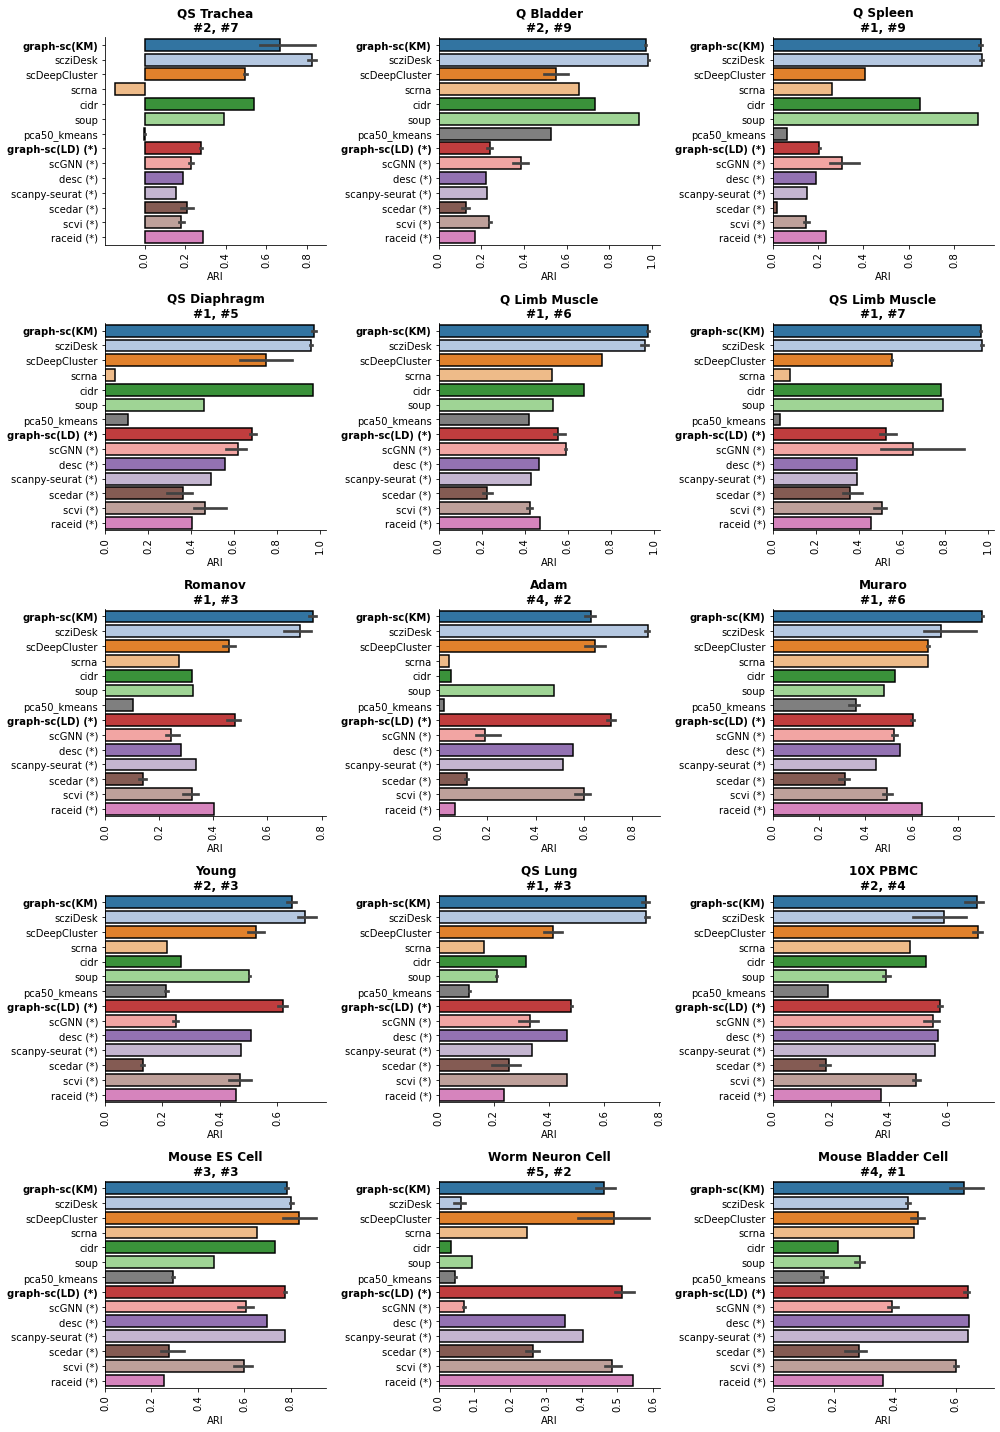

In [6]:
nb_cols=3
nb_rows=5
plt.figure(figsize=(14, 4*nb_rows))

for i in range(len(datasets)):
    ds = datasets[i]
    ax = plt.subplot(nb_rows,nb_cols,i + 1)
    sns.barplot(y = "method_name", x="ARI", data = all_data[all_data["dataset"] == ds].sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    title = dataset_names.get(ds, ds).replace("\n"," ")
    title += f"\n#{int(rankKM[ds])}, #{int(rankLD[ds])}"
    plt.title(title, fontweight = "bold")
    plt.ylabel("")
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold') 
    sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_ARI_barplot.pdf", bbox_inches='tight')

# Computational time analysis

In [3]:
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_gae_cpu.pkl")
df_k_cpu = df[[
    'dataset',
    'kmeans_ari',
    'kmeans_nmi',
    'run',
    "tot_kmeans_time"

]].rename(columns={
    'kmeans_ari': "ARI",
    'kmeans_nmi': "NMI",
    "tot_kmeans_time": "time"
})
df_k_cpu["method"] = "graph-sc(KM) CPU"

df_l_cpu = df[[
    'dataset',
    'leiden_ari',
    'leiden_nmi',
    'run',
    "tot_leiden_time"

]].rename(columns={
    'leiden_ari': "ARI",
    'leiden_nmi': "NMI",
    "tot_leiden_time": "time"
})
df_l_cpu["method"] = "graph-sc(LD) CPU"

all_data_comp = pd.concat([all_data, df_k_cpu, df_l_cpu])
bold_names = {
    'graph-sc(KM)': "$\\bf{graph-sc(KM)}$",
    'graph-sc(KM) CPU': "$\\bf{graph-sc(KM)}$ $\\bf{(CPU)}$",
    'graph-sc(LD)': "$\\bf{graph-sc(LD)}$",
    'graph-sc(LD) CPU': "$\\bf{graph-sc(LD)}$ $\\bf{(CPU)}$"
}
all_data_comp["method"] = all_data_comp["method"].apply(lambda x: bold_names.get(x, x))
# ordered_methods = [
#     "graph-sc(KM)",
#     "graph-sc(KM) CPU",
#     'graph-sc(LD)',
#     'graph-sc(LD) CPU',
#     'scziDesk',
#     'scDeepCluster',
#     'scrna',
#     'cidr',
#     'soup',
#     'pca_kmeans',
#     'desc',
#     'scanpy-seurat',
#     'scedar',
#     'scvi',
#     'raceid',
# ]

all_data_comp = all_data_comp.groupby("method")[["time"]].mean()


ref_time = all_data_comp.groupby("method")["time"].mean()[bold_names.get("graph-sc(KM)")]

all_data_comp["Factor"] = all_data_comp["time"].apply(lambda x: x/ref_time)
all_data_comp= all_data_comp.sort_values(by = "time")

all_data_comp = all_data_comp.rename(columns={"time": "Avg time(sec)"})

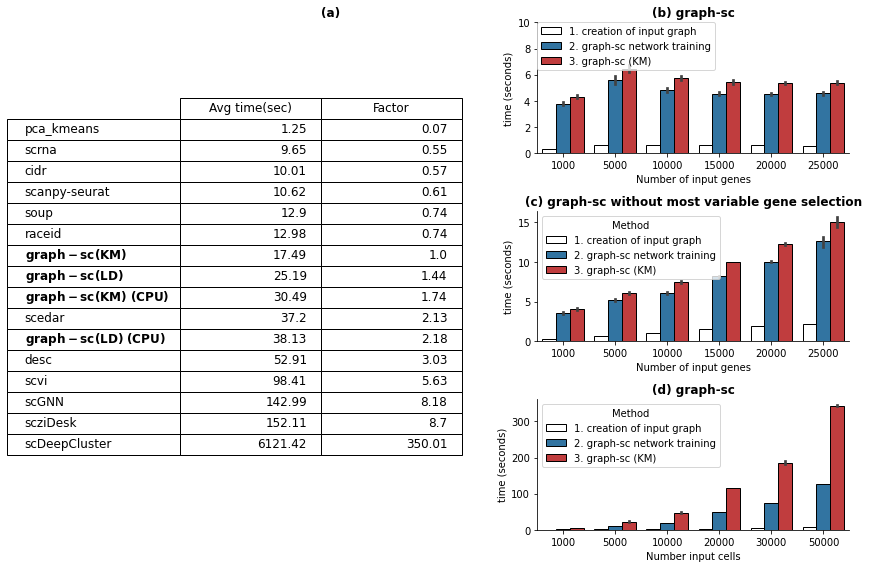

In [4]:
colours = ['white', '#1f77b4', '#d62728']
plt.figure(figsize = (12,8))
ax = plt.subplot(1, 2, 1)
ax.axis("off")
table = ax.table(cellText=all_data_comp.round(2).values,
          rowLabels=all_data_comp.index,
          colLabels=all_data_comp.columns,
          loc='center left'
        )
plt.title("(a)", fontweight = "bold")
table.scale(0.9, 1.5)
table.set_fontsize(12)

###
ax = plt.subplot(3, 2, 2)
plt.title("(b) graph-sc", fontweight = "bold")
sc = pd.read_pickle(f"../output/pickle_results/real_data/real_data_scalability_genes_pca.pkl")

sc = sc[["nb_genes", "time_graph", "time_training", "tot_kmeans_time"]]
sc["nb_genes"] =sc["nb_genes"].astype(int)
sc = sc.rename(columns = {"nb_genes": "Nb genes", 
                          "tot_kmeans_time": "3. graph-sc (KM)", 
                          "time_training": "2. graph-sc network training",
                          "time_graph": "1. creation of input graph"
                         })

sc = pd.melt(sc, id_vars="Nb genes",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

sns.barplot(x = "Nb genes", y= "value",hue = "Method", data = sc,
           palette=colours,
           edgecolor='black',)
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
plt.ylabel("time (seconds)")
plt.xlabel("Number of input genes")
plt.ylim((0,10))
sns.despine()


ax = plt.subplot(3, 2, 4)
plt.title("(c) graph-sc without most variable gene selection", fontweight = "bold")
sc = pd.read_pickle(f"../output/pickle_results/real_data/real_data_scalability_genes.pkl")

sc = sc[["nb_genes", "time_graph", "time_training", "tot_kmeans_time"]]
sc["nb_genes"] =sc["nb_genes"].astype(int)
sc = sc.rename(columns = {"nb_genes": "Nb genes", 
                          "tot_kmeans_time": "3. graph-sc (KM)", 
                          "time_training": "2. graph-sc network training",
                          "time_graph": "1. creation of input graph"
                         })

sc = pd.melt(sc, id_vars="Nb genes",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

sns.barplot(x = "Nb genes", y= "value",hue = "Method", data = sc,
           palette=colours,
           edgecolor='black',)
plt.ylabel("time (seconds)")
plt.xlabel("Number of input genes")
sns.despine()



####
ax = plt.subplot(3, 2, 6)
plt.title("(d) graph-sc", fontweight = "bold")
sc = pd.read_pickle(f"../output/pickle_results/real_data/real_data_scalability_cells.pkl")

sc = sc[["nb_cells", "time_graph", "time_training", "tot_kmeans_time"]]
sc["nb_cells"] =sc["nb_cells"].astype(int)
sc = sc.rename(columns = {"nb_cells": "Nb cells", 

                          "tot_kmeans_time": "3. graph-sc (KM)", 
                          "time_training": "2. graph-sc network training",
                          "time_graph": "1. creation of input graph"})

sc = pd.melt(sc, id_vars="Nb cells",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

sns.barplot(x = "Nb cells", y= "value",hue = "Method", data = sc,
           palette=colours,
           edgecolor='black',)
plt.ylabel("time (seconds)")
plt.xlabel("Number input cells")
sns.despine()

plt.tight_layout()
plt.savefig(f"../diagrams/computational_analysis.pdf", bbox_inches='tight')

In [ ]:
sc = pd.read_pickle(f"../output/pickle_results/real_data/real_data_scalability_cells.pkl")
sc.groupby("nb_cells").mean()

# Nb input genes analysis

In [4]:
nb_genes = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_genes.pkl")
nb_genes["ordered_dataset"] = nb_genes["dataset"].apply(lambda x: ordered_datasets[x])

ordered_genes = [500, 1000, 2000, 3000, 4000, 5000, 'all',]

ordered_genes = dict(zip(ordered_genes, np.arange(len(ordered_genes))))

nb_genes["order"] = nb_genes["nb_genes"].apply(lambda x: ordered_genes[x])

def format_label(x, boxplot = False):
    if x == "all":
        if boxplot:
            return "all genes"
        else:
            return "all\ngenes"
    if x == "random_half":
        if boxplot:
            return "random 1/2 genes"
        else:
            return "random 1/2\ngenes"
    else:
        return str(int(x))
nb_genes["nb_genes_boxplot"] = nb_genes["nb_genes"].apply(lambda x:format_label(x, boxplot = True) )
nb_genes["nb_genes"] = nb_genes["nb_genes"].apply(lambda x:format_label(x) )

nb_genes["dataset_label"] = nb_genes["dataset"].apply(
    lambda x: dataset_names.get(x, x))
nb_genes=nb_genes.sort_values(by= "order",  ascending = True)

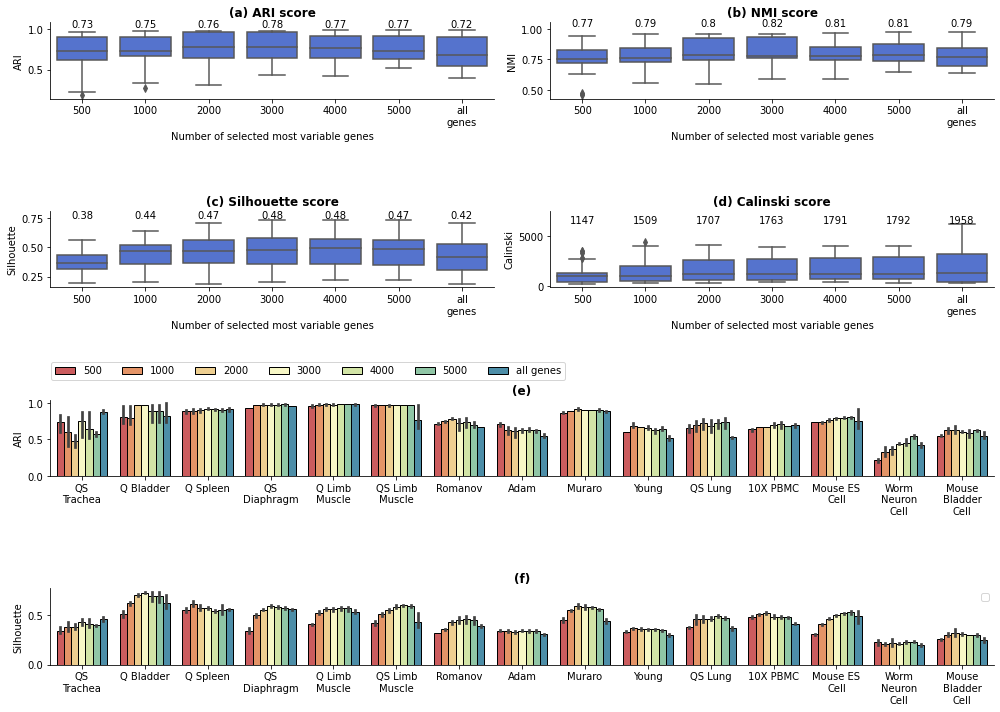

In [5]:
plt.figure(figsize=(14, 10))

ax = plt.subplot(421)
sns.boxplot(data=nb_genes,
            x="nb_genes",
            y='kmeans_ari',
            ax=ax,
            color="royalblue")
plt.ylabel("ARI")
plt.xlabel("Number of selected most variable genes")
means = nb_genes.groupby(['nb_genes'])[['kmeans_ari', "order"
        ]].mean().sort_values(by = "order").round(2).values[:, 0]
mean_labels = [str(np.round(s, 3)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

sns.despine()
plt.title("(a) ARI score", fontweight="bold")
ax = plt.subplot(422)
sns.boxplot(data=nb_genes,
            x="nb_genes",
            y='kmeans_nmi',
            ax=ax,
            color="royalblue")
plt.ylabel("NMI")
plt.xlabel("Number of selected most variable genes")
sns.despine()
plt.title("(b) NMI score", fontweight="bold")
means = nb_genes.groupby(['nb_genes'])[['kmeans_nmi', "order"
        ]].mean().sort_values(by = "order").round(2).values[:, 0]
mean_labels = [str(np.round(s, 3)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))



ax = plt.subplot(423)
sns.boxplot(data=nb_genes,
            x="nb_genes",
            y='kmeans_sil',
            ax=ax,
            color="royalblue")
plt.ylabel("Silhouette")
plt.xlabel("Number of selected most variable genes")
sns.despine()
plt.title("(c) Silhouette score", fontweight="bold")
means = nb_genes.groupby(['nb_genes'])[['kmeans_sil', "order"
        ]].mean().sort_values(by = "order").round(2).values[:, 0]
mean_labels = [str(np.round(s, 3)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.75, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = plt.subplot(424)
sns.boxplot(data=nb_genes,
            x="nb_genes",
            y='kmeans_cal',
            ax=ax,
            color="royalblue")
plt.ylabel("Calinski")
plt.xlabel("Number of selected most variable genes")
sns.despine()
plt.title("(d) Calinski score", fontweight="bold")
means = nb_genes.groupby(['nb_genes'])[['kmeans_cal', "order"
        ]].mean().sort_values(by = "order").astype(int).values[:, 0]
mean_labels = [str(np.round(s, 3)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 6300, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 1000))


ax = plt.subplot(413)
sns.barplot(data=nb_genes.sort_values(by=["ordered_dataset", "order"]),
            x="dataset_label",
            y="kmeans_ari",
            hue="nb_genes_boxplot",
            palette = "Spectral",
            edgecolor='black',
            ax=ax)
plt.legend(bbox_to_anchor=(0.001, 1.5), loc=2, borderaxespad=0., ncol=7)
plt.ylabel("ARI")
# plt.grid()
plt.title("(e)", fontweight="bold")
plt.xlabel("")
sns.despine()

ax = plt.subplot(414)
sns.barplot(data=nb_genes.sort_values(by=["ordered_dataset", "order"]),
            x="dataset_label",
            y="kmeans_sil",
            hue="nb_genes_boxplot",
            palette = "Spectral",
            edgecolor='black',
            ax=ax)
plt.legend([])
# plt.grid()
plt.ylabel("Silhouette")
plt.title("(f)", fontweight="bold")
plt.xlabel("")
sns.despine()

plt.tight_layout()
plt.savefig(f"../diagrams/{category}_nb_genes.pdf", bbox_inches='tight')

In [6]:
a = nb_genes[nb_genes["nb_genes"] == '3000']["kmeans_ari"].values

b = nb_genes[nb_genes["nb_genes"] == "all\ngenes"]["kmeans_ari"].values

print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

Ttest_indResult(statistic=1.4204720838230518, pvalue=0.07950188768724656)


In [ ]:
# a = nb_genes[nb_genes["nb_genes"] == '500']["kmeans_nmi_0"].values

# b = nb_genes[nb_genes["nb_genes"] == "all\ngenes"]["kmeans_nmi_0"].values

# print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

# Robustness to the number of selected cells

In [3]:
train_size = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_cells.pkl")


In [4]:
methods_no_clust = [
    'graph-sc(LD)',
    'scGNN',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]
all_data1 = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

In [5]:

all_data1 = all_data1.groupby(["method", "dataset"]).std()/all_data1.groupby(["method", "dataset"]).mean()
all_data1 = all_data1.abs()
all_data1= all_data1.reset_index()

# all_data1 =all_data1.groupby(["method"]).std().reset_index()
all_data1["order"] = all_data1["method"].apply(lambda x: ordered_methods_map[x])
all_data1["method"] = all_data1["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
all_data1.head()

,method,dataset,ARI,NMI,Silhouette,Calinski,time,order
0,cidr,10X_PBMC,0.0,0.0,0.0,0.0,0.003617,4
1,cidr,Adam,0.0,0.0,0.0,0.0,0.036482,4
2,cidr,Muraro,0.0,0.0,0.0,0.0,0.010331,4
3,cidr,Quake_10x_Bladder,0.0,0.0,0.0,0.0,0.023061,4
4,cidr,Quake_10x_Limb_Muscle,0.0,0.0,0.0,0.0,0.012892,4


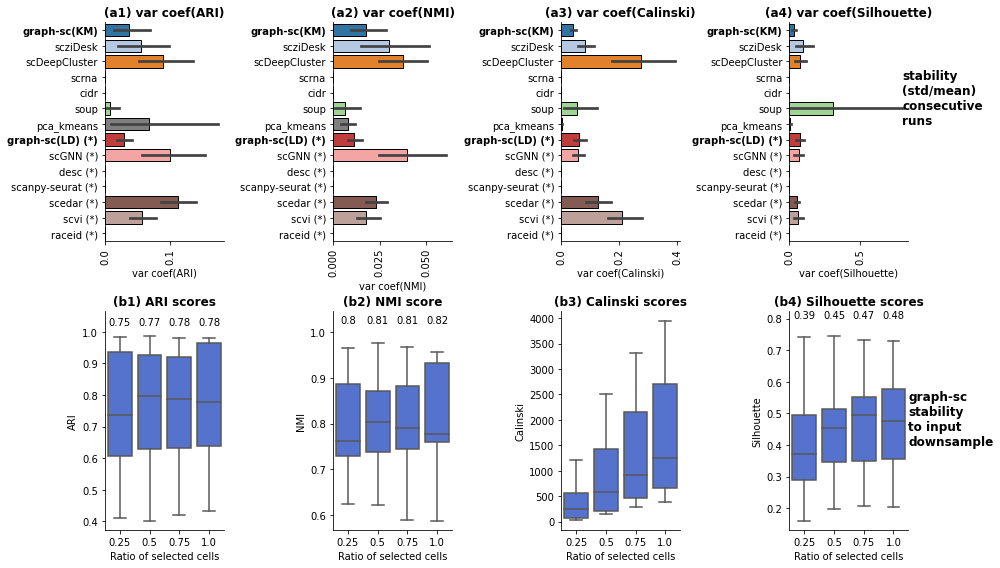

In [6]:
plt.figure(figsize=(14, 8))
letters = ["(a)", "(b)", "(c)", "(d)",
           "(e)", "(f)","(g)" ,"(h)",
           "(i)","(j)","(k)", "(l)"]
titles = ["real data"]
nb_rows=2
i = 0
ax = plt.subplot(nb_rows,4, 1)

sns.barplot(y = "method", x="ARI", data = all_data1.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1)
plt.xticks(rotation = 90)
plt.title(f"(a1) var coef(ARI)", fontweight = "bold")
sns.despine()
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
plt.xlabel("var coef(ARI)")
plt.ylabel("")

ax = plt.subplot(nb_rows,4, 2)

sns.barplot(y = "method", x="NMI", data = all_data1.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1)
plt.xticks(rotation = 90)
plt.title(f"(a2) var coef(NMI)", fontweight = "bold")

sns.despine()
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
plt.xlabel("var coef(NMI)")
plt.ylabel("")


ax = plt.subplot(nb_rows,4, 3)
sns.barplot(y = "method", x="Calinski", data = all_data1.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1)
plt.xticks(rotation = 90)
plt.title(f"(a3) var coef(Calinski)", fontweight = "bold")
sns.despine()
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
plt.xlabel("var coef(Calinski)")

plt.ylabel("")


ax = plt.subplot(nb_rows,4, 4)
sns.barplot(y = "method", x="Silhouette", data = all_data1.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1)
plt.xticks(rotation = 90)
plt.title(f"(a4) var coef(Silhouette)", fontweight = "bold")

sns.despine()
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
plt.xlabel("var coef(Silhouette)")
plt.ylabel("")


plt.text(0.8, 6, "stability\n(std/mean)\nconsecutive\nruns", fontweight = "bold", fontsize = 12)




## stability input cells
ax = plt.subplot(245)
g = sns.boxplot(data = train_size, x = "train_size", y='kmeans_ari', ax = ax, color="royalblue")
means = train_size.groupby(['train_size'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b1) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

# plt.ylabel("")

ax = plt.subplot(246)
g = sns.boxplot(data = train_size, x = "train_size", y='kmeans_nmi', ax = ax, color="royalblue")
means = train_size.groupby(['train_size'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("NMI")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b2) NMI score",  fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))



ax = plt.subplot(247)
sns.boxplot(data = train_size, x = "train_size", y='kmeans_cal', ax = ax, color="royalblue")

plt.ylabel("Calinski")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b3) Calinski scores",  fontweight = "bold")

ax = plt.subplot(248)
sns.boxplot(data = train_size, x = "train_size", y='kmeans_sil', ax = ax, color="royalblue")
means = train_size.groupby(['train_size'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(pos[tick], 0.80, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("Silhouette")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b4) Silhouette scores",  fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(3.5, 0.4, "graph-sc\nstability\nto input\ndownsample", fontweight = "bold", fontsize = 12)



plt.tight_layout()
plt.savefig(f"../diagrams/{category}_stability.pdf", bbox_inches='tight')

In [ ]:
# a = train_size[train_size["train_size"] == 1]["kmeans_ari"].values

# b = train_size[train_size["train_size"] == 0.5]["kmeans_ari"].values

# print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

In [ ]:
# a = train_size[train_size["train_size"] == 1]["kmeans_sil"].values

# b = train_size[train_size["train_size"] == 0.5]["kmeans_sil"].values

# print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

# GNN analysis

In [ ]:
category = "real_data"
data = pd.read_pickle(
                            f"../output/pickle_results/{category}/{category}_graph_networks.pkl"
                        )

# data.groupby("model_name").mean()

models = ['GraphConv', 'GATConv', 'EdgeConv', 'SAGEConvMean', 'GINSum',]
model_names = {'SAGEConvMean': "SAGE", 'GINSum': "GIN", 'GraphConv': "GCN", 'GATConv': "GAT\nConv",
              'EdgeConv' : "Edge\nConv"}

data = data[data["model_name"].isin(models)]
data["model_name"]  = data["model_name"].apply(lambda x: model_names.get(x, x))

In [ ]:
plt.figure(figsize=(14, 4))
ax = plt.subplot(141)
g = sns.boxplot(data = data.sort_values(by= "model_name"),
                x = "model_name", y='kmeans_ari', ax = ax, color="royalblue")
means = data.groupby(['model_name'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("")
sns.despine()
plt.title("(a) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = plt.subplot(142)
g = sns.boxplot(data = data.sort_values(by= "model_name"),
                x = "model_name", y='kmeans_nmi', ax = ax, color="royalblue")
means = data.groupby(['model_name'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("NMI")
plt.xlabel("")
sns.despine()
plt.title("(b) NMI score",  fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))



ax = plt.subplot(143)
sns.boxplot(data = data.sort_values(by= "model_name"),
            x = "model_name", y='kmeans_cal', ax = ax, color="royalblue")
means = data.groupby(['model_name'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(pos[tick], 16000, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 600))
plt.ylabel("Calinski")
plt.xlabel("")
sns.despine()
plt.title("(c) Calinski scores",  fontweight = "bold")

ax = plt.subplot(144)
sns.boxplot(data = data.sort_values(by= "model_name"),
            x = "model_name", y='kmeans_sil', ax = ax, color="royalblue")
means = data.groupby(['model_name'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(pos[tick], 0.76, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("Silhouette")
plt.xlabel("")
sns.despine()
plt.title("(d) Silhouette scores",  fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

plt.tight_layout()
plt.savefig(f"../diagrams/gnn_sota_models.pdf", bbox_inches='tight')

# Edges analysis

In [ ]:
category = "real_data"
results = pd.read_pickle(
    f"../output/pickle_results/{category}/{category}_edges.pkl")

In [ ]:
results.groupby("nb_edges").mean()

In [ ]:
fig = plt.figure(figsize=(14, 8) )
gs = fig.add_gridspec(2, 4)
data = results[results["nb_edges"]>=0]

data["nb_edges_label"] = data["nb_edges"].apply(lambda x:f"{int(x*100)} %")
data.groupby("nb_edges").mean()

ax = fig.add_subplot(gs[0, 0])
g = sns.boxplot(data=data,
                x="nb_edges_label",
                y='kmeans_ari',
                ax=ax,
                color="royalblue")
means = data.groupby(['nb_edges_label'
                      ])[['kmeans_ari', 'nb_edges'
                          ]].mean().sort_values(by="nb_edges").values[:, 0]
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        1.02,
        mean_labels[tick],
        horizontalalignment=
        'center', 
    )
plt.ylabel("ARI")
plt.xlabel("Selected largest weight edges")
sns.despine()
plt.title("(a1) ARI scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = fig.add_subplot(gs[0, 1])
g = sns.boxplot(data=data,
                x="nb_edges_label",
                y='kmeans_nmi',
                ax=ax,
                color="royalblue")
means = data.groupby(['nb_edges_label'
                      ])[['kmeans_nmi', 'nb_edges'
                          ]].mean().sort_values(by="nb_edges").values[:, 0]
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        1.02,
        mean_labels[tick],
        horizontalalignment=
        'center', 
    )
plt.ylabel("NMI")
plt.xlabel("Selected largest weight edges")
sns.despine()
plt.title("(a2) NMI scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = fig.add_subplot(gs[0, 2])
g = sns.boxplot(data=data,
                x="nb_edges_label",
                y='kmeans_cal',
                ax=ax,
                color="royalblue")
means = data.groupby(['nb_edges_label'
                      ])[['kmeans_cal', 'nb_edges'
                          ]].mean().sort_values(by="nb_edges").values[:, 0]
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        4000,
        mean_labels[tick],
        horizontalalignment=
        'center', 
    )
plt.ylabel("Calinski")
plt.xlabel("Selected largest weight edges")
sns.despine()
plt.title("(a3) Calinski scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = fig.add_subplot(gs[0, 3])
g = sns.boxplot(data=data,
                x="nb_edges_label",
                y='kmeans_sil',
                ax=ax,
                color="royalblue")
means = data.groupby(['nb_edges_label'
                      ])[['kmeans_sil', 'nb_edges'
                          ]].mean().sort_values(by="nb_edges").values[:, 0]
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        0.76,
        mean_labels[tick],
        horizontalalignment=
        'center', 
    )
plt.ylabel("ARI")
plt.xlabel("Selected largest weight edges")
sns.despine()
plt.title("(a4) Silhouette scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(3.5, 0.4, "Select\npercentage\nlargest\nweight\nedges", fontweight = "bold", fontsize = 12)

## Smallest weight edges
data = results[results["nb_edges"]<=0]
data["nb_edges"] = data["nb_edges"].abs()
data["nb_edges_label"] = data["nb_edges"].apply(lambda x:f"{int(x*100)} %")


ax = fig.add_subplot(gs[1, 0])
g = sns.boxplot(data=data.sort_values(by="nb_edges"),
                x="nb_edges_label",
                y='kmeans_ari',
                ax=ax,
                color="royalblue")
means = data.groupby(['nb_edges_label'
                      ])[['kmeans_ari', 'nb_edges'
                          ]].mean().sort_values(by="nb_edges").values[:, 0]
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        1.02,
        mean_labels[tick],
        horizontalalignment=
        'center', 
    )
plt.ylabel("ARI")
plt.xlabel("Selected smallest weight edges")
sns.despine()
plt.title("(b1) ARI scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = fig.add_subplot(gs[1, 1])
g = sns.boxplot(data=data.sort_values(by="nb_edges"),
                x="nb_edges_label",
                y='kmeans_nmi',
                ax=ax,
                color="royalblue")
means = data.groupby(['nb_edges_label'
                      ])[['kmeans_nmi', 'nb_edges'
                          ]].mean().sort_values(by="nb_edges").values[:, 0]
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        1.02,
        mean_labels[tick],
        horizontalalignment=
        'center', 
    )
plt.ylabel("NMI")
plt.xlabel("Selected smallest weight edges")
sns.despine()
plt.title("(b2) NMI scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = fig.add_subplot(gs[1, 2])
g = sns.boxplot(data=data.sort_values(by="nb_edges"),
                x="nb_edges_label",
                y='kmeans_cal',
                ax=ax,
                color="royalblue")
means = data.groupby(['nb_edges_label'
                      ])[['kmeans_cal', 'nb_edges'
                          ]].mean().sort_values(by="nb_edges").values[:, 0]
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        4000,
        mean_labels[tick],
        horizontalalignment=
        'center', 
    )
plt.ylabel("Calinski")
plt.xlabel("Selected smallest weight edges")
sns.despine()
plt.title("(b3) Calinski scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = fig.add_subplot(gs[1, 3])
g = sns.boxplot(data=data.sort_values(by="nb_edges"),
                x="nb_edges_label",
                y='kmeans_sil',
                ax=ax,
                color="royalblue")
means = data.groupby(['nb_edges_label'
                      ])[['kmeans_sil', 'nb_edges'
                          ]].mean().sort_values(by="nb_edges").values[:, 0]
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        0.76,
        mean_labels[tick],
        horizontalalignment=
        'center', 
    )
plt.ylabel("ARI")
plt.xlabel("Selected smallest weight edges")
sns.despine()
plt.title("(b4) Silhouette scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(3.5, 0.4, "Select\npercentage\nsmallest\nweight\nedges", fontweight = "bold", fontsize = 12)


plt.tight_layout()
plt.savefig(f"../diagrams/edges_analysis.pdf", bbox_inches='tight')

# Neural Architecture Search

In [25]:
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_gae_layers.pkl")
layers.head()

,ae_end,dataset,hidden,hidden_dim,kmeans_ari,kmeans_cal,kmeans_nmi,kmeans_pred,kmeans_sil,kmeans_time,nb_genes,run,leiden_ari,leiden_cal,leiden_nmi,leiden_pred,leiden_sil,leiden_time
0,1.614899e+09,Muraro,[200],100,0.8837,2061.160196,0.8480,"[5, 0, 0, 6, 6, 1, 0, 0, 0, 6, 6, 5, 0, 5, 0, ...",0.532955,4.852042,5000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.614899e+09,Muraro,[200],100,0.8892,2372.334970,0.8448,"[0, 3, 2, 8, 2, 3, 0, 6, 0, 0, 6, 3, 0, 6, 8, ...",0.532320,4.179153,5000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.614899e+09,Muraro,[200],100,0.9055,2135.525385,0.8578,"[0, 3, 5, 0, 0, 1, 3, 8, 8, 0, 0, 1, 0, 5, 1, ...",0.518973,4.643629,5000.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1.614899e+09,Muraro,[100],100,0.8776,2138.372894,0.8452,"[0, 2, 4, 2, 4, 5, 3, 5, 2, 2, 0, 0, 3, 3, 3, ...",0.513238,4.333299,5000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.614900e+09,Muraro,[100],100,0.8898,2230.958721,0.8525,"[2, 7, 7, 2, 3, 0, 0, 3, 4, 0, 7, 4, 0, 2, 7, ...",0.536579,4.402196,5000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


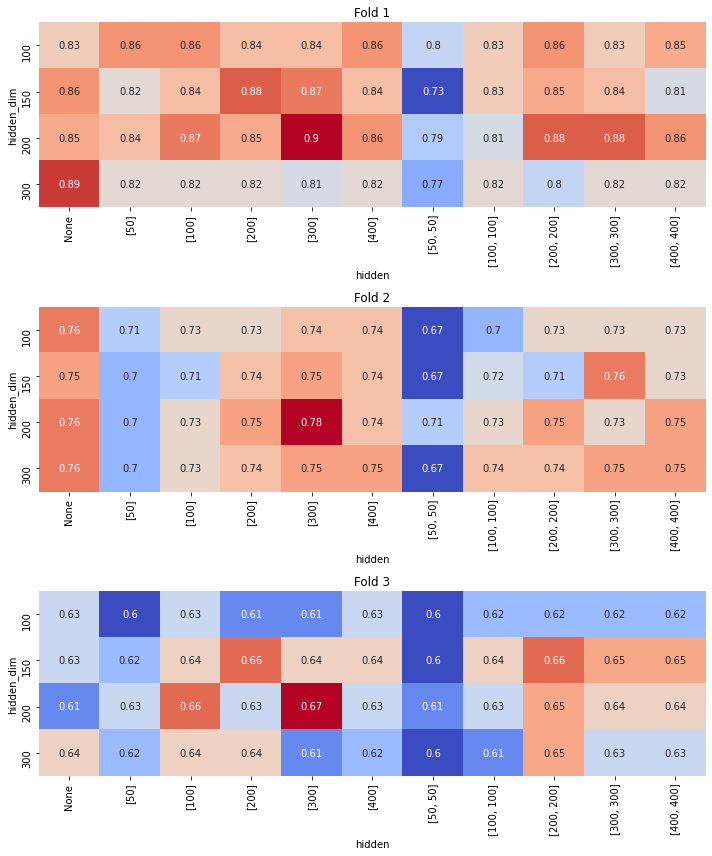

In [34]:
plt.figure(figsize = (10, 12))
ax = plt.subplot(311)
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_gae_layers.pkl")
layers = layers[layers["dataset"].isin(np.array(datasets)[np.arange(0, 5)])]

layers["nb_layers"] = layers["hidden"].apply(lambda x: len(x.split(",")))

layers["nb_layers"] = layers.apply(
    lambda x: x["nb_layers"] + 1 if x["hidden"] != "None" else x["nb_layers"],
    axis=1)

layers = layers[layers["nb_genes"] == 3000]

r = layers.groupby(
    ["hidden_dim", "hidden"])["kmeans_ari"].mean().round(2).unstack("hidden")
r = r[[
    'None',
    '[50]',
    '[100]',
    '[200]',
    '[300]',
    '[400]',
    '[50, 50]',
    '[100, 100]',
    '[200, 200]',
    '[300, 300]',
    '[400, 400]',
]]
sns.heatmap(r, annot=True, cmap="coolwarm", fmt='.3g', ax=ax, cbar=False)
plt.title("Fold 1")

ax = plt.subplot(312)
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_gae_layers.pkl")
layers = layers[layers["dataset"].isin(np.array(datasets)[np.arange(5, 10)])]

layers["nb_layers"] = layers["hidden"].apply(lambda x: len(x.split(",")))

layers["nb_layers"] = layers.apply(
    lambda x: x["nb_layers"] + 1 if x["hidden"] != "None" else x["nb_layers"],
    axis=1)

layers = layers[layers["nb_genes"] == 3000]

r = layers.groupby(
    ["hidden_dim", "hidden"])["kmeans_ari"].mean().round(2).unstack("hidden")
r = r[[
    'None',
    '[50]',
    '[100]',
    '[200]',
    '[300]',
    '[400]',
    '[50, 50]',
    '[100, 100]',
    '[200, 200]',
    '[300, 300]',
    '[400, 400]',
]]
sns.heatmap(r, annot=True, cmap="coolwarm", fmt='.3g', ax=ax, cbar=False)
plt.title("Fold 2")


ax = plt.subplot(313)
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_gae_layers.pkl")
layers = layers[layers["dataset"].isin(np.array(datasets)[np.arange(10, 15)])]

layers["nb_layers"] = layers["hidden"].apply(lambda x: len(x.split(",")))

layers["nb_layers"] = layers.apply(
    lambda x: x["nb_layers"] + 1 if x["hidden"] != "None" else x["nb_layers"],
    axis=1)

layers = layers[layers["nb_genes"] == 3000]

r = layers.groupby(
    ["hidden_dim", "hidden"])["kmeans_ari"].mean().round(2).unstack("hidden")
r = r[[
    'None',
    '[50]',
    '[100]',
    '[200]',
    '[300]',
    '[400]',
    '[50, 50]',
    '[100, 100]',
    '[200, 200]',
    '[300, 300]',
    '[400, 400]',
]]
sns.heatmap(r, annot=True, cmap="coolwarm", fmt='.3g', ax=ax, cbar=False)
plt.title("Fold 3")
plt.tight_layout()
plt.savefig(f"../diagrams/grid_search_folds.pdf", bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(14, 12)  #, constrained_layout=True
                 )
gs = fig.add_gridspec(3, 4)

## PCA size
data = pd.read_pickle(
    f"../output/pickle_results/real_data/real_data_pca_size.pkl")
data["pca_size"] = data["pca_size"].astype(int)

ax = fig.add_subplot(gs[0, 0])
g = sns.boxplot(data=data,
                x="pca_size",
                y='kmeans_ari',
                ax=ax,
                color="royalblue")
means = data.groupby(['pca_size'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        1.02,
        mean_labels[tick],
        horizontalalignment=
        'center',  #size='x-small', color='w', weight='semibold'
    )
plt.ylabel("ARI")
plt.xlabel("Size of node input features\n(PCA)")
sns.despine()
plt.title("(a1) ARI scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = fig.add_subplot(gs[0, 1])
g = sns.boxplot(data=data,
                x="pca_size",
                y='kmeans_nmi',
                ax=ax,
                color="royalblue")
means = data.groupby(['pca_size'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        1.02,
        mean_labels[tick],
        horizontalalignment=
        'center',  #size='x-small', color='w', weight='semibold'
    )
plt.ylabel("NMI")
plt.xlabel("Size of node input features\n(PCA)")
sns.despine()
plt.title("(a2) NMI score", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = fig.add_subplot(gs[0, 2])
sns.boxplot(data=data, x="pca_size", y='kmeans_cal', ax=ax, color="royalblue")
means = data.groupby(['pca_size'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        13500,
        mean_labels[tick],
        horizontalalignment=
        'center',  #size='x-small', color='w', weight='semibold'
    )
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 600))
plt.ylabel("Calinski")
plt.xlabel("Size of node input features\n(PCA)")
sns.despine()
plt.title("(a3) Calinski scores", fontweight="bold")

ax = fig.add_subplot(gs[0, 3])
sns.boxplot(data=data, x="pca_size", y='kmeans_sil', ax=ax, color="royalblue")
means = data.groupby(['pca_size'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        0.82,
        mean_labels[tick],
        horizontalalignment=
        'center',  #size='x-small', color='w', weight='semibold'
    )
plt.ylabel("Silhouette")
plt.xlabel("Size of node input features\n(PCA)")
sns.despine()
plt.title("(a4) Silhouette scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(5.5, 0.4, "PCA\nsize", fontweight="bold", fontsize=12)

### Learning rate

data = pd.read_pickle(f"../output/pickle_results/real_data/real_data_lr.pkl")
# data["lr"] = data["lr"].astype(int)
ax = fig.add_subplot(gs[1, 0])
g = sns.boxplot(data=data, x="lr", y='kmeans_ari', ax=ax, color="royalblue")
means = data.groupby(['lr'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        1.02,
        mean_labels[tick],
        horizontalalignment=
        'center',  #size='x-small', color='w', weight='semibold'
    )
plt.ylabel("ARI")
plt.xlabel("Learning rate")
sns.despine()
plt.title("(b1) ARI scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
ax = fig.add_subplot(gs[1, 1])
g = sns.boxplot(data=data, x="lr", y='kmeans_nmi', ax=ax, color="royalblue")
means = data.groupby(['lr'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        1.02,
        mean_labels[tick],
        horizontalalignment=
        'center',  #size='x-small', color='w', weight='semibold'
    )
plt.ylabel("NMI")
plt.xlabel("Learning rate")
sns.despine()
plt.title("(b2) NMI score", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = fig.add_subplot(gs[1, 2])
sns.boxplot(data=data, x="lr", y='kmeans_cal', ax=ax, color="royalblue")
means = data.groupby(['lr'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        6500,
        mean_labels[tick],
        horizontalalignment=
        'center',  #size='x-small', color='w', weight='semibold'
    )
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 600))
plt.ylabel("Calinski")
plt.xlabel("Learning rate")
sns.despine()
plt.title("(b3) Calinski scores", fontweight="bold")

ax = fig.add_subplot(gs[1, 3])
sns.boxplot(data=data, x="lr", y='kmeans_sil', ax=ax, color="royalblue")
means = data.groupby(['lr'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick, label in zip(pos, ax.get_yticklabels()):
    ax.text(
        pos[tick],
        0.92,
        mean_labels[tick],
        horizontalalignment=
        'center',  #size='x-small', color='w', weight='semibold'
    )
plt.ylabel("Silhouette")
plt.xlabel("Learning rate")
sns.despine()
plt.title("(b4) Silhouette scores", fontweight="bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(4.5, 0.4, "Learning\nrate", fontweight="bold", fontsize=12)

ax = fig.add_subplot(gs[2, 0])
import matplotlib.image as mpimg
plt.title("(c) Encoder architecture", fontweight="bold")
plt.imshow(mpimg.imread('../diagrams/encoder.jpg'),)
plt.axis("off")
ax = fig.add_subplot(gs[2, 1:])
r = r[[
    'None',
    '[50]',
    '[100]',
    '[200]',
    '[300]',
    '[400]',
    '[50, 50]',
    '[100, 100]',
    '[200, 200]',
    '[300, 300]',
    '[400, 400]',
]]
sns.heatmap(r, annot=True, cmap="coolwarm", fmt='.3g', ax=ax, cbar=False)
plt.ylabel("(1) GCN sizes")
plt.xlabel("(2) Linear layers sizes")
plt.title("(d) Grid search, ARI scores", fontweight="bold")
plt.tight_layout()
plt.savefig(f"../diagrams/grid_search.pdf", bbox_inches='tight')

# Clustering analysis

In [7]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_gae_features.pkl")
scDeepCluster = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scDeepCluster.pkl")
scDeepCluster["method"] = "scDeepCluster"



sczi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_sczi.pkl")
sczi["method"] = "scziDesk"

desc = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scGNN.pkl")
desc["method"] = "scGNN"
# desc["pred"] = desc["pred"].apply(lambda x: list(x.values))
datasets = [ 'Muraro','Quake_10x_Limb_Muscle', 'Quake_10x_Bladder',#'Muraro',
            "Adam"
           ]
# datasets = ['10X_PBMC', "Romanov",#'Quake_10x_Spleen', 
#             'Quake_Smart-seq2_Diaphragm',
#        'Quake_Smart-seq2_Limb_Muscle', 'Quake_Smart-seq2_Lung']



# datasets = [ 'Young', 'mouse_ES_cell',
#        'mouse_bladder_cell', 'worm_neuron_cell', 'Quake_Smart-seq2_Trachea', 'Romanov',]

In [8]:
def get_2d(all_data, dataset):
    ours = all_data[(all_data["dataset"] == dataset) & (all_data["run"] == 0)]
    ari = round(ours["ARI"].values[0], 2)
    emb = ours["features"].values[0]
    n_clust = np.unique(ours["pred"].values[0]).shape[0]

    X_embedded = TSNE(n_components=2, random_state = 0).fit_transform(emb)

    X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])

    X_embedded["clusters"] = ours["pred"].values[0]
    X_embedded["clusters"] = X_embedded["clusters"].apply(lambda x : f"c {x}")
    return X_embedded, ari, n_clust

In [9]:
embedding_map = {}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


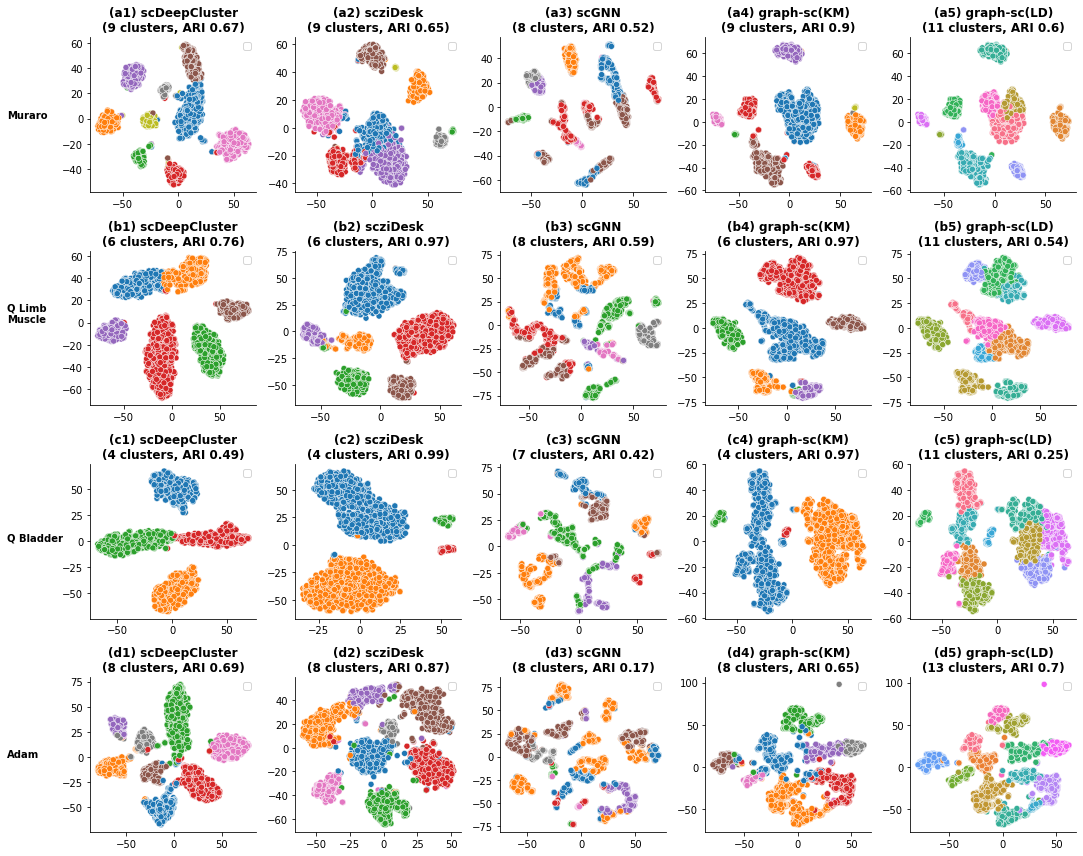

In [10]:
n = len(datasets)
titles = ["a", "b", "c", "d", "e", "f"]
plt.figure(figsize = (15, 3*n))
n_cols = 5
nb_rows = n
for i in range(n):
    dataset = datasets[i]
    # scDeepCluster
    X_embedded, ari, n_clust = get_2d(scDeepCluster, dataset)
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+1)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="clusters",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    plt.title(f"({titles[i]}1) scDeepCluster\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    xmin, xmax = ax.get_xlim()
    plt.text(xmin - (xmax - xmin )/2, 0,dataset_names.get(dataset, dataset), fontweight = "bold")
    sns.despine()
    
    # sczi
    X_embedded, ari, n_clust = get_2d(sczi, dataset)
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+2)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="clusters",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    plt.title(f"({titles[i]}2) scziDesk\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    # desc
    X_embedded, ari, n_clust = get_2d(desc, dataset)
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+3)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="clusters",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    plt.title(f"({titles[i]}3) scGNN\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    
    # OURS
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    if 'cell_names' in data_mat.keys():
        cell_names = data_mat['cell_names'][()]
    else:
        cell_names = Y

    ours = df[(all_data["dataset"] == dataset) & (df["run"] == 0)]

    emb = ours["features"].values[0]

    X_embedded = TSNE(n_components=2).fit_transform(emb)

    X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])
    X_embedded[dataset] = cell_names

    X_embedded["K Means"] = ours["kmeans_pred"].values[0]
    X_embedded["Leiden"] = ours["leiden_pred"].values[0]

    X_embedded["K Means"] = X_embedded["K Means"].apply(lambda x : f"c {x}")
    X_embedded["Leiden"] = X_embedded["Leiden"].apply(lambda x : f"c {x}")
    embedding_map[dataset] = X_embedded
    # plot
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+4)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="K Means",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    ari = round(ours["kmeans_ari"].values[0], 2)
    n_clust = X_embedded["K Means"].unique().shape[0]
    plt.title(f"({titles[i]}4) graph-sc(KM)\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    xmin, xmax = ax.get_xlim()
#     plt.text(xmax, 0,dataset_names.get(dataset, dataset).replace('\n', " ")  , fontweight = "bold")
    sns.despine()
    
    
    
    # plot
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+5)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="Leiden",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    ari = round(ours["leiden_ari"].values[0], 2)
    n_clust = X_embedded["Leiden"].unique().shape[0]
    plt.title(f"({titles[i]}5) graph-sc(LD)\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    

    
plt.tight_layout()

plt.savefig(f"../diagrams/{category}_TSNE_clusters-orig.pdf", bbox_inches='tight')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


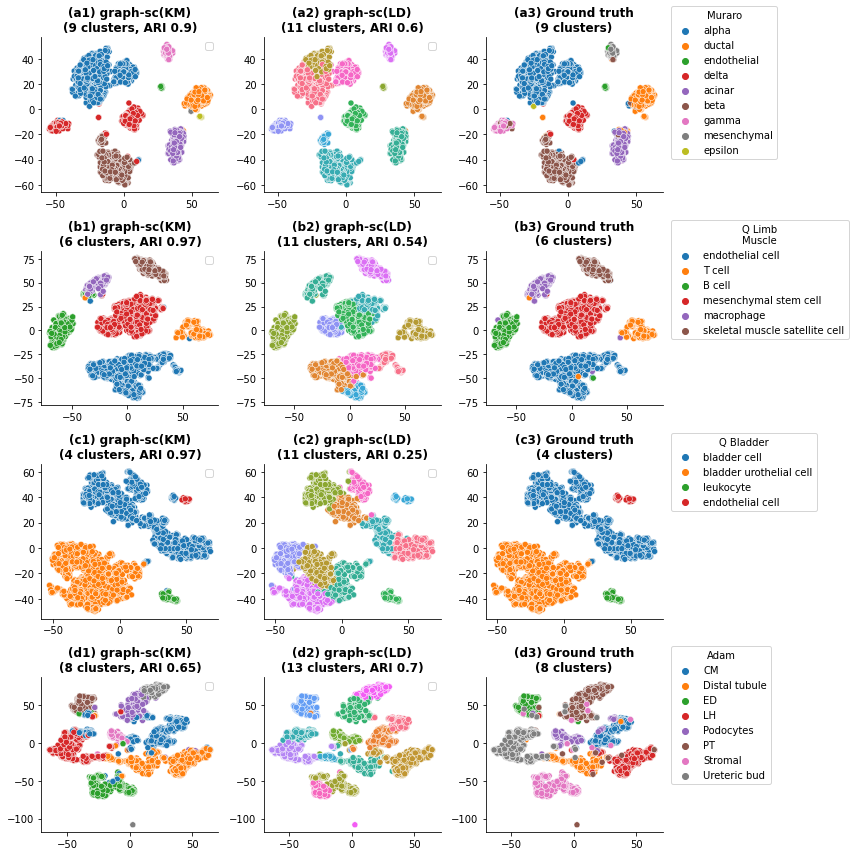

In [11]:
n = len(datasets)
titles = ["a", "b", "c", "d", "e", "f"]
plt.figure(figsize = (12, 3*n))
n_cols = 3
nb_rows = n
for i in range(n):
    dataset = datasets[i]
    # OURS
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    cell_names = data_mat['cell_names'][()]

    ours = df[(all_data["dataset"] == dataset) & (df["run"] == 0)]

    emb = ours["features"].values[0]

#     X_embedded = TSNE(n_components=2, random_state = 0).fit_transform(emb)

#     X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])
#     X_embedded[dataset] = cell_names

#     X_embedded["K Means"] = ours["kmeans_pred"].values[0]
#     X_embedded["Leiden"] = ours["leiden_pred"].values[0]

#     X_embedded["K Means"] = X_embedded["K Means"].apply(lambda x : f"c {x}")
#     X_embedded["Leiden"] = X_embedded["Leiden"].apply(lambda x : f"c {x}")
    X_embedded = embedding_map[dataset]
    # plot
    
    
    ax = plt.subplot(nb_rows, n_cols,  i*n_cols+1)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="K Means",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    ari = round(ours["kmeans_ari"].values[0], 2)
    n_clust = X_embedded["K Means"].unique().shape[0]
    plt.title(f"({titles[i]}1) graph-sc(KM)\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+2)
    sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="Leiden",
               ax = ax,
              )
    ari = round(ours["leiden_ari"].values[0], 2)
    n_clust = X_embedded["Leiden"].unique().shape[0]
    plt.title(f"({titles[i]}2) graph-sc(LD)\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    plt.legend([])
    plt.xlabel("")
    plt.ylabel("")
#     if i == 0:
#         plt.suptitle("Panel b")
    sns.despine()

    ax = plt.subplot(nb_rows, n_cols,  i*n_cols+3)
    sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue=dataset,
               ax = ax
              )
    plt.legend(bbox_to_anchor=(1.05,1.2), loc=2, borderaxespad=0., ncol = 1, 
               title = dataset_names.get(dataset, dataset) )
    n_clust = X_embedded["K Means"].unique().shape[0]
    plt.title(f"({titles[i]}3) Ground truth\n({n_clust} clusters)", fontweight = "bold")
    plt.xlabel("")
    plt.ylabel("")
    sns.despine()
    
plt.tight_layout()

plt.savefig(f"../diagrams/{category}_ground_truth.pdf", bbox_inches='tight')

In [ ]:
dataset = 'Quake_10x_Bladder'#'Quake_10x_Limb_Muscle'

In [ ]:
data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
X = np.array(data_mat['X'])
Y = np.array(data_mat['Y'])

cell_names = data_mat['cell_names'][()]

ours = df[(all_data["dataset"] == dataset) & (df["run"] == 0)]

pred = ours["kmeans_pred"].values[0]
idx = np.where(pred!= Y)[0]
print(len(idx), X.shape)
print(len(Y), adjusted_rand_score(Y, pred))

In [ ]:
cell_names = data_mat['cell_names'][()]

In [ ]:
Y, cell_names

In [ ]:
Xb = (X>0).astype(int)

In [ ]:
idx0 = np.where(pred == 0)[0]
idx1 = np.where(pred == 1)[0]
idx2 = np.where(pred == 2)[0]
idx3 = np.where(pred == 3)[0]
pred[idx1] = 0
pred[idx0] = 1
idx = np.where(pred!= Y)[0]
print(len(idx))
pred[idx][:20], Y[idx][:20]

In [ ]:
pred[idx2] = 3
pred[idx3] = 2
idx = np.where(pred!= Y)[0]
print(len(idx))

In [ ]:
len(idx), pred[idx][:20], Y[idx][:20]

In [ ]:
plt.hist(X.mean( axis = 1), bins = 30, log= True)

plt.hist(X[idx].mean( axis = 1), bins = 30, log= True)

In [ ]:
plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.title("(a) Average cell expression value \nin Q Bladder", fontweight = "bold")
plt.hist(X.mean( axis = 1), bins = 30);
plt.xlabel("Average cell expression value")
plt.ylabel("Frequency")
plt.subplot(122)
plt.title("(b) Average expression value in cells \npredicted in the wrong cluster", fontweight = "bold")
plt.xlabel("Average cell expression value")
plt.ylabel("Frequency")
plt.hist(X[idx] .mean( axis = 1), bins = 30);
sns.despine()
plt.savefig(f"../diagrams/{category}_wrong_predictions.pdf", bbox_inches='tight')

# Data augmentation analysis

In [ ]:
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_layers_new.pkl")
dropout = layers[layers["layers"] == "[200, 40, 60]"]

In [ ]:
plt.figure(figsize = (13,6))
ax = plt.subplot(241)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_ari', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(a) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(-3, 0.6, "Ratio of\nmasked\ngenes\n(dropout\nlayer)", 
         fontweight = "bold", fontsize = 12)
# plt.ylabel("")


ax = plt.subplot(242)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_nmi', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("nmi")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(b) NMI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))



ax = plt.subplot(243)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_sil', ax = ax, color="royalblue")
plt.ylabel("Silhouette")
means = dropout.groupby(['dropout'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.87, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("NN dropout ratio" )
sns.despine()
plt.title("(c) Silhouette scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = plt.subplot(244)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_cal', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 18000, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("cal")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(d) Calinski scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 2000))
#####
noise = pd.read_pickle(f"../output/pickle_results/real_data/real_data_noise.pkl")
ax = plt.subplot(245)
sns.boxplot(data = noise, x = "noise", y='kmeans_ari', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("std added noise")
sns.despine()
plt.title("(e) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(-3, 0.8, "Noise\nadded\nto input\ndata", 
         fontweight = "bold", fontsize = 12)
# plt.ylabel("")


ax = plt.subplot(246)
sns.boxplot(data = noise, x = "noise", y='kmeans_nmi', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("nmi")
plt.xlabel("std added noise")
sns.despine()
plt.title("(f) NMI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = plt.subplot(247)
sns.boxplot(data = noise, x = "noise", y='kmeans_sil', ax = ax, color="royalblue")
plt.ylabel("Silhouette")
means = noise.groupby(['noise'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.87, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("std added noise")
sns.despine()
plt.title("(g) Silhouette scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = plt.subplot(248)
sns.boxplot(data = noise, x = "noise", y='kmeans_cal', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 27000, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("cal")
plt.xlabel("std added noise")
sns.despine()
plt.title("(h) Calinski scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 2000))

plt.tight_layout()
plt.savefig(f"../diagrams/{category}_data_augmentation.pdf", bbox_inches='tight')

# ARI correlation

In [ ]:
df = all_data[['dataset', "method", 'ARI', 'NMI','Silhouette', 'Calinski']]
df.head()

df['Silhouette'] = df['Silhouette'].astype(float)
df['Calinski'] = df['Calinski'].astype(float)

corr_ari = None

for method in df.method.unique():
    desc_m = df[df["method"] == method]
    desc_m = desc_m.corr()[["ARI"]].rename(columns={"ARI": method})
    if corr_ari is None:
        corr_ari = desc_m
    else:
        corr_ari = pd.concat([corr_ari, desc_m], axis =1)

corr_ari = corr_ari.round(2)

idx = corr_ari.index.values
idx = [f"corr(ARI-{x})" for x in idx]

corr_ari = corr_ari.reset_index()

corr_ari["index"] = idx
corr_ari

corr_ari = corr_ari[corr_ari["index"]!= "corr(ARI-ARI)"]
corr_ari = corr_ari[corr_ari["index"]!= "corr(ARI-Calinski)"]


corr_sil = None

for method in df.method.unique():
    desc_m = df[df["method"] == method]
    desc_m = desc_m.corr()[["Silhouette"]].rename(columns={"Silhouette": method})
    if corr_sil is None:
        corr_sil = desc_m
    else:
        corr_sil = pd.concat([corr_sil, desc_m], axis =1)

corr_sil = corr_sil.round(2)

idx = corr_sil.index.values
idx = [f"corr(Silhouette-{x})" for x in idx]

corr_sil = corr_sil.reset_index()

corr_sil["index"] = idx
corr_sil

corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-Silhouette)"]
corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-ARI)"]
corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-Calinski)"]


corr_ari = pd.concat([corr_ari, corr_sil])

corr_ari  = corr_ari.set_index("index", drop = True)

In [ ]:
# plt.figure(figsize = (12, 2))
# ax = plt.gca()
# sns.heatmap(corr_ari[ordered_methods], annot = True, cmap = "coolwarm", ax = ax)
# plt.ylabel("");
# plt.savefig(f"../diagrams/ari_corr_arielation.pdf", bbox_inches='tight')

# Correlation score vs sparsity, etc

In [ ]:
desc = pd.read_excel("../output/pickle_results/real_data/description.xlsx")
desc = desc[['dataset', 'nb_clusters', 'sparsity', 'max_value',
       'non_zero_mean', 'non_zero_median', 'non_zero_skew', 'non_zero_kurosis']]
desc.head()


df = all_data[['dataset', "method", "ARI"]]

desc = pd.merge(desc, df, on = "dataset", how = "right")

corr = None

for method in desc.method.unique():
    desc_m = desc[desc["method"] == method]
    desc_m = desc_m.corr()[["ARI"]].rename(columns={"ARI": method})
    if corr is None:
        corr = desc_m
    else:
        corr = pd.concat([corr, desc_m], axis =1)

corr = corr.round(2)

corr = corr[corr.index != "ARI"].reset_index()

labels = {
    'nb_clusters': "Nb of clusters",
    'sparsity': "Sparsity (ratio of 0 values)",
    'max_value': "Max value",
    'non_zero_mean': "Mean value",
    'non_zero_median': "Median value",
    'non_zero_skew': "Skew",
    'non_zero_kurosis': "Kurtosis"
}
corr["index"] = corr["index"].apply(lambda x: labels[x])
corr = corr.set_index("index", drop = True)
corr = corr[ordered_methods]
corr

In [ ]:
plt.figure(figsize = (12, 9))
ax = plt.subplot(311)
plt.title("(a) Correlation of clustering scores", fontweight = "bold")
sns.heatmap(corr_ari[ordered_methods], annot = True, cmap = "coolwarm", ax = ax)
plt.ylabel("");

ax = plt.subplot(212)
plt.title("(b) Correlation between the ARI score and dataset properties", fontweight = "bold")
sns.heatmap(corr, annot = True, cmap = "coolwarm", ax = ax)
plt.ylabel("");
plt.tight_layout()
plt.savefig(f"../diagrams/meta_correlation.pdf", bbox_inches='tight')

In [ ]:
sel_methods = ['graph-sc(KM)', 'graph-sc(LD)', 'scziDesk', 'scDeepCluster', 'desc', 'scanpy-seurat']

In [ ]:
sel_desc = desc[desc.method.isin(sel_methods)]

In [ ]:
sel_desc = sel_desc.rename(columns = {"nb_clusters": "Nb. of clusters" })

In [ ]:
g = sns.FacetGrid(sel_desc, col="method",  col_wrap=3, height=3, 
                  ylim=(0, 1)
                 )
g.map(sns.regplot, "Nb. of clusters", "ARI")
plt.savefig(f"../diagrams/perf_by_nb_of_clusters.pdf", bbox_inches='tight')

# Scalability

In [ ]:
# sc = pd.read_pickle(f"../output/pickle_results/balanced_data/balanced_data_scalability_cells.pkl")

# sc = sc[["nb_cells", "t_k", "t_l", "t_training"]]
# sc["nb_cells"] =sc["nb_cells"].astype(int)
# sc = sc.rename(columns = {"nb_cells": "Nb cells", 
#                           "t_k": "2. Complete gae +KMeans", 
#                           "t_l": "3. Complete gae +Leiden", 
#                           "t_training": "1. Representation learning only"})

# sc = pd.melt(sc, id_vars="Nb cells",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

# sns.barplot(x = "Nb cells", y= "value",hue = "Method", data = sc)
# plt.ylabel("time (seconds)")
# sns.despine()

# sc = pd.read_pickle(f"../output/pickle_results/balanced_data/balanced_data_scalability_genes.pkl")

# sc = sc[["nb_genes", "t_k", "t_l", "t_training"]]
# sc["nb_genes"] =sc["nb_genes"].astype(int)
# sc = sc.rename(columns = {"nb_genes": "Nb genes", 
#                           "t_k": "2. Complete gae +KMeans", 
#                           "t_l": "3. Complete gae +Leiden", 
#                           "t_training": "1. Representation learning only"})

# sc = pd.melt(sc, id_vars="Nb genes",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

# sns.barplot(x = "Nb genes", y= "value",hue = "Method", data = sc)
# plt.ylabel("time (seconds)")
# sns.despine()

# Nb input epochs

In [ ]:
# nb_epochs = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_epochs.pkl")
# nb_epochs["nb_epochs"] = nb_epochs["nb_epochs"].astype("int")

In [ ]:
# plt.figure(figsize = (10, 3))
# ax = plt.subplot(121)
# sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_ari', ax = ax)
# plt.ylabel("ARI")
# plt.xlabel("Number of training epochs")
# sns.despine()
# plt.title("(a) ARI")
# ax = plt.subplot(122)
# sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_sil', ax = ax)
# plt.ylabel("Silhouette")
# plt.xlabel("Number of training epochs")
# sns.despine()
# plt.title("(b) Silhouette")
# plt.savefig(f"../diagrams/{category}_nb_epochs.pdf", bbox_inches='tight')

# Noise analysis

In [ ]:
# noise = pd.read_pickle(f"../output/pickle_results/real_data/real_data_noise.pkl")

# plt.figure(figsize = (10, 3))
# ax = plt.subplot(121)
# sns.boxplot(data = noise, x = "noise", y='kmeans_ari_0', ax = ax)
# means = noise.groupby(['noise'])['kmeans_ari_0'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick], 1.01, mean_labels[tick], 
#             horizontalalignment='center', #size='x-small', color='w', weight='semibold'
#            )
# plt.ylabel("ARI")
# plt.xlabel("Noise std")
# sns.despine()
# plt.title("(a) ARI")
# ax = plt.subplot(122)
# sns.boxplot(data = noise, x = "noise", y='kmeans_nmi_0', ax = ax)
# plt.ylabel("NMI")
# means = noise.groupby(['noise'])['kmeans_nmi_0'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick], 1.01, mean_labels[tick], 
#             horizontalalignment='center', #size='x-small', color='w', weight='semibold'
#            )
# plt.xlabel("Noise std")
# sns.despine()
# plt.title("(b) NMI")


In [ ]:
import scanpy.api as sc

In [ ]:
??sc.pp.highly_variable_genes

# Worm dataset analysis

In [ ]:
dataset_names_worm = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES Cell',
    'mouse_ES_cell_select_2100': 'Mouse ES Cell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron Cell (2100)',
    'worm_neuron_cell': 'Worm Neuron Cell',
    'mouse_bladder_cell': 'Mouse Bladder Cell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder  Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS Trachea',
    'Quake_Smart-seq2_Diaphragm': 'QS Diaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb Muscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb Muscle',
    'Adam': "Adam",
    'Muraro': "Muraro",
    'Romanov': "Romanov",
    'Young': "Young",
}
worm_order =dict(zip(list(dataset_names_worm.keys()), np.arange(len(dataset_names_worm))))
df = pd.read_pickle(
    f"{path}output/pickle_results/real_data/real_data_dataset_tuning.pkl")
df = df.groupby(["dataset",
                 "nb_genes"])[["kmeans_ari_0", "sparsity"
                               ]].mean().unstack("nb_genes").reset_index()
df.columns = ["dataset", "500", "1500", "5000", "sparsity", "s1", "s2"]
df["order"] = df["dataset"].apply(
    lambda x: worm_order.get(x, x))
df = df.sort_values(by = "order")
df["dataset"] = df["dataset"].apply(
    lambda x: dataset_names_worm.get(x, x))

df = df.drop(["s1", "s2", "order"], axis=1).set_index("dataset").round(3)

df

In [ ]:
nb_genes = pd.read_pickle(f"../output/pickle_results/real_data/real_data_worm.pkl")
nb_genes["nb_genes"] = nb_genes["nb_genes"].astype(int)

In [ ]:
plt.figure(figsize = (10, 7))
ax = plt.subplot(221)
g = sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_ari_0', ax = ax)
ylim = nb_genes.groupby("nb_genes").max()["kmeans_ari_0"].max() + 0.01
means = nb_genes.groupby(['nb_genes'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], ylim, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Nb of selected genes in Worm Neuron Cell dataset")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(223)
ylim = nb_genes.groupby("nb_genes").max()["kmeans_nmi_0"].max()+ 0.01
sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_nmi_0', ax = ax)
means = nb_genes.groupby(['nb_genes'])['kmeans_nmi_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], ylim, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("NMI")
plt.xlabel("Nb of selected genes in Worm Neuron Cell dataset")
sns.despine()
plt.title("(b) NMI")
ax = plt.subplot(1,2,2)
sns.heatmap(df, annot = True, cmap = "coolwarm",fmt='.3g', ax = ax)
plt.ylabel("");
plt.title("(c)")
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_worm.pdf", bbox_inches='tight')